In [1]:
import rioxarray
import rasterio
import numpy as np
import qinfer
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import geopandas as gpd
from shapely.geometry.point import Point
import shapely.affinity
import subprocess
from osgeo import gdal
import pygeos
import json
import os
import pandas as pd
from tqdm import tqdm
import requests
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import esda
import libpysal
from scipy import stats

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/qinfer/parallel.py:51: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


In [2]:
dam_id = 'TX00019'
scene_num = '0'
# dam_id = 'TX08008'
# scene_num = '3'

In [3]:
census_gdf = gpd.read_file('./census_geometry/tl_2020_block_texas.geojson')
census_gdf.rename(columns={'geoid': 'GEOID'}, inplace=True)
census_gdf = census_gdf[['GEOID', 'geometry']]
census_gdf = census_gdf.to_crs(epsg=4326)
census_gdf.head(1)

GEOID                                           geometry
0  480679503001009  POLYGON ((-94.15007 33.16598, -94.15003 33.166...

In [4]:
# reclassify, resample, and polygonize raster flood inundation map
def polygonize_fim(rasterfile_path):
    # first determine pixel size to resample to 10x
    xres = 0
    yres = 0
    filename = rasterfile_path.split("/")[-1].split(".")[-2]
    target_path = '/'.join(rasterfile_path.split('/')[:-1])

    out = subprocess.run(["gdalinfo","-json",rasterfile_path],stdout=subprocess.PIPE)
    raster_meta = json.loads(out.stdout.decode('utf-8'))
    if 'geoTransform' in raster_meta:
        xres = raster_meta['geoTransform'][1]
        yres = raster_meta['geoTransform'][5]
        xres = xres * 10
        yres = yres * 10

    if (xres != 0) and (yres != 0):
        # resample raster
        save_path = target_path +"/"+ filename + "_resample.tiff"
        subprocess.run(["gdalwarp","-r","bilinear","-of","GTiff","-tr",str(xres),str(yres),rasterfile_path,save_path])

        # now reclassify raster
        water_lvl = [0, 2, 6, 15, np.inf]  # Original inundation map value (underwater in feet)
        water_lvl_recls = [-9999, 1, 2, 3, 4]
        reclass_file = target_path + "/" + filename + "_reclass.tiff"
        outfile = "--outfile="+reclass_file
        subprocess.run(["gdal_calc.py","-A",save_path,outfile,"--calc=-9999*(A<=0)+1*((A>0)*(A<=2))+2*((A>2)*(A<=6))+3*((A>6)*(A<=15))+4*(A>15)","--NoDataValue=-9999"],stdout=subprocess.PIPE)

        # now polygonize the reclassified raster
        geojson_out = "%s/%s.json" % (target_path, filename)
        subprocess.run(["gdal_polygonize.py", reclass_file, "-b", "1", geojson_out, filename, "value"])

        inundation_polygons = gpd.read_file(geojson_out)
        inundation_polygons = inundation_polygons.loc[inundation_polygons['value'] != -9999]  # Remove pixels of null value

        # drop invalid geometries
        inundation_polygons = inundation_polygons.loc[inundation_polygons['geometry'].is_valid, :]

#         # Entire coverage of inundation map
#         inundation_dis_geom = inundation_polygons.geometry.unary_union

        # Coverage for each class of inundation map
        inundation_per_cls = inundation_polygons.dissolve(by='value')
        inundation_per_cls.reset_index(inplace=True)

        # Save the polygonized results
        #poly_out = "%s/%s.geojson" % (self.target_path,filename)
        #inundation_polygons.to_file(poly_out)

        # remove all temp files
        os.remove(save_path)
        os.remove(reclass_file)
        os.remove(geojson_out)

        # inundation_per_cls: GeoDataFrame 
        return inundation_per_cls # , inundation_dis_geom

    
def calculate_ellipse(dam_id, scene_num, fim_path, rescale_factor):

    # Load inundation map
    inund_map = rioxarray.open_rasterio(fim_path, masked=True, parse_coordinates=True).squeeze('band', drop=True) 
    
    # Down sampling the inundation map
    new_width = round(inund_map.rio.width * rescale_factor)
    new_height = round(inund_map.rio.height * rescale_factor)
    inund_map_resample = inund_map.rio.reproject(dst_crs= inund_map.rio.crs, 
                                                 shape=(new_height, new_width),
                                                 resampling=rasterio.enums.Resampling.bilinear
                                                )
    print(f"{dam_id}_{scene_num} Completed: Down sampling the inundation map")
    
    # Extract non-null raster cells to points
    da_ = inund_map_resample.where(inund_map_resample != inund_map.rio.encoded_nodata)  # -9999 is the null value in the provided inundation map
    stacked_da_ = da_.stack(stacked_x=['y', 'x'])
    points_ary = np.column_stack((stacked_da_[stacked_da_.notnull()].coords['x'], 
                                  stacked_da_[stacked_da_.notnull()].coords['y'])
                                )
    
    print(f"{dam_id}_{scene_num} Completed: Raster Cells are extracted to points")
    
    # Calculate ellipse (MVEE; minimum-volume enclosing ellipse)
    A, centroid = qinfer.utils.mvee(points_ary)
    U, D, V = la.svd(A)
    
    ## x, y radii.
    rx, ry = 1./np.sqrt(D)
    ## Define major and minor semi-axis of the ellipse.
    dx, dy = 2 * rx, 2 * ry
    ma_axis, mi_axis = max(dx, dy), min(dx, dy)
    
    ## Calculate orientation of ellipse
    arcsin = -1. * np.rad2deg(np.arcsin(V[0][0]))
    arccos = np.rad2deg(np.arccos(V[0][1]))
    # Orientation angle (with respect to the x axis counterclockwise).
    alpha = arccos if arcsin > 0. else -1. * arccos

    ## Create a circle of radius 0.5 around center point:
    circ = shapely.geometry.Point(centroid).buffer(0.5)
    ellipse  = shapely.affinity.scale(circ, ma_axis, mi_axis)
    ellipse_rotate = shapely.affinity.rotate(ellipse, alpha)
    
    return ellipse_rotate, points_ary
    

def extract_inundated_area_geoid(fim_path, census_gdf, dam_id, scene_num):

    # Destination dataframe to save the results
    inund_area_geoid_df = pd.DataFrame({'Dam_ID': pd.Series(dtype='str'),
                                        'Scenario': pd.Series(dtype='str'),
                                        'GEOID': pd.Series(dtype='str'),
                                        'Class': pd.Series(dtype='str')})        

    inund_per_cls_gdf = polygonize_fim(fim_path)
    print(f'Completed: Tiff to Polygon conversion for {dam_id}_{scene_num}')

    # Create STRtree for census_gdf
    census_geoms = pygeos.from_shapely(census_gdf['geometry'].values)
    census_geoms_tree = pygeos.STRtree(census_geoms, leafsize=50)

    # Extract census tract intersecting with each class of inundation map
    for cls in inund_per_cls_gdf['value'].unique():
        inund_per_cls_geom = pygeos.from_shapely(inund_per_cls_gdf.loc[inund_per_cls_gdf['value'] == cls, 'geometry'].values[0])
        query_inund_census_geom = census_geoms_tree.query(inund_per_cls_geom, predicate='intersects')
        inund_census_gdf = census_gdf.loc[query_inund_census_geom]

        for geoid_ in inund_census_gdf['GEOID'].to_list():
            new_row = pd.DataFrame({'Dam_ID': dam_id, 'Scenario': scene_num, 'GEOID': geoid_, 'Class': cls}, index=[0])
            inund_area_geoid_df = pd.concat([new_row, inund_area_geoid_df]).reset_index(drop=True)
    print(f'Completed: Inundated census tract extraction for {dam_id}_{scene_num}')

    # Caclulate minimum-volume enclosing ellipse (mvee) of the inundation map to extract benchmark area
    ellipse, points = calculate_ellipse(dam_id, scene_num, fim_path, rescale_factor=1/100)
    print(f'Completed: Ellipsoid calculation for {dam_id}_{scene_num}')
    
    # Extract benchmark area (not inundated) intersecting with the ellipse
    ellipse_geom = pygeos.from_shapely(ellipse)    
    query_benchmark_census_geom = census_geoms_tree.query(ellipse_geom, predicate='intersects')
    benchmark_census_gdf = census_gdf.loc[query_benchmark_census_geom]

    for geoid_ in benchmark_census_gdf['GEOID'].to_list():
        new_row = pd.DataFrame({'Dam_ID': dam_id, 'Scenario': scene_num, 'GEOID': geoid_, 'Class': 0}, index=[0])
        inund_area_geoid_df = pd.concat([new_row, inund_area_geoid_df]).reset_index(drop=True)
    print(f'Completed: Benchmark area extraction for {dam_id}_{scene_num}')

    return inund_area_geoid_df, inund_per_cls_gdf, ellipse

fim_path = f'./NID_Inundation_Tiff_MH_Breach/{dam_id}_{scene_num}.tiff'
fim_geoid, fim_gdf, ellipse = extract_inundated_area_geoid(fim_path, census_gdf, dam_id, scene_num)

Creating output file that is 4033P x 3915L.
Processing ./NID_Inundation_Tiff_MH_Breach/TX00019_0.tiff [1/1] : 0Using internal nodata values (e.g. -9999) for image ./NID_Inundation_Tiff_MH_Breach/TX00019_0.tiff.
Copying nodata values from source ./NID_Inundation_Tiff_MH_Breach/TX00019_0.tiff to destination ./NID_Inundation_Tiff_MH_Breach/TX00019_0_resample.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...Several drivers matching json extension. Using GeoJSON
Creating output ./NID_Inundation_Tiff_MH_Breach/TX00019_0.json of format GeoJSON.
100 - done.
Completed: Tiff to Polygon conversion for TX00019_0
Completed: Inundated census tract extraction for TX00019_0
TX00019_0 Completed: Down sampling the inundation map
TX00019_0 Completed: Raster Cells are extracted to points
Completed: Ellipsoid calculation for TX00019_0
Completed: Benchmark area extraction for TX00019_0


In [5]:
fim_geoid

Dam_ID Scenario            GEOID Class
0      TX00019        0  482019801001001     0
1      TX00019        0  482012415032007     0
2      TX00019        0  482019801001039     0
3      TX00019        0  482012415032006     0
4      TX00019        0  482019801001003     0
...        ...      ...              ...   ...
82630  TX00019        0  481576755032001     1
82631  TX00019        0  481576755032002     1
82632  TX00019        0  481576755032075     1
82633  TX00019        0  481576755032079     1
82634  TX00019        0  481576755032078     1

[82635 rows x 4 columns]

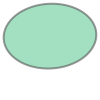

In [6]:
ellipse

epsg:4326


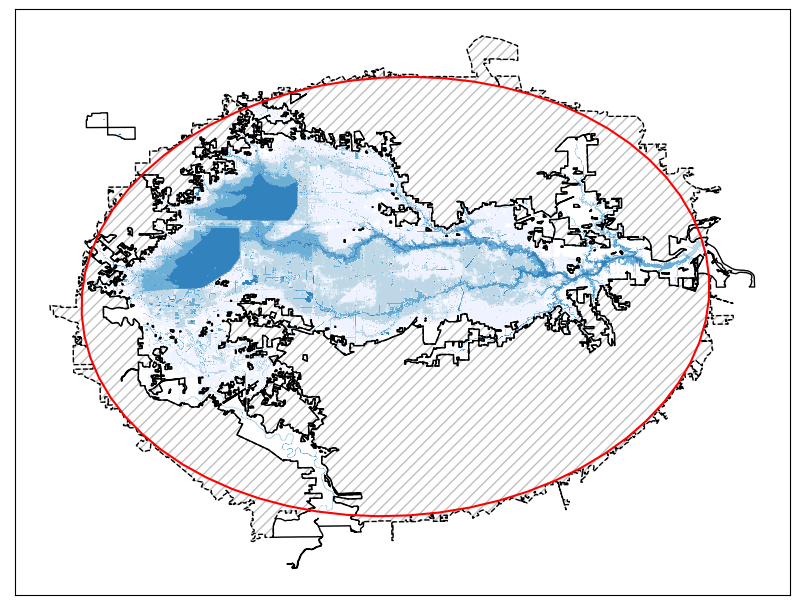

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

color_brewer = ['#eff3ff','#bdd7e7','#6baed6','#3182bd']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=4)

fim_census = fim_geoid.merge(census_gdf, on='GEOID')
fim_census = gpd.GeoDataFrame(fim_census, geometry=fim_census['geometry'], crs='EPSG:4326')
fim_census['Class'] = fim_census['Class'].astype(int)
fim_census = fim_census.groupby(['Dam_ID', 'Scenario', 'GEOID'], 
                                group_keys=False).apply(lambda x:x.loc[x['Class'].idxmax()]
                                                         ).reset_index(drop=True)
fim_census = fim_census.set_crs(epsg=4326)
print(fim_census.crs)
non_inund_tract = fim_census.loc[fim_census['Class'] == 0]
non_inund_tract = non_inund_tract.dissolve(by='Dam_ID')

inund_tract = fim_census.loc[fim_census['Class'] != 0]
inund_tract = inund_tract.dissolve(by='Dam_ID')

fim_gdf.plot('value', ax=ax, cmap=cm)
inund_tract.boundary.plot(ax=ax, color='black', lw=1)
non_inund_tract.boundary.plot(ax=ax, color='black', lw=1, linestyle='dashed')
non_inund_tract.plot(color='white', edgecolor='grey', linewidth = 0.5, hatch='///', alpha = 0.5, ax=ax)

gpd.GeoDataFrame([0], geometry=[ellipse]).boundary.plot(ax=ax, color='Red')

ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

In [8]:
def call_census_table(state_list, table, key):
    
    result_df = pd.DataFrame()
    
    # querying at census tract level
    for state in tqdm(state_list):
        if table.startswith('group'):
            address = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,{table}&for=tract:*&in=state:{state}&in=county:*'
        elif table.startswith('DP'):
            address = f'https://api.census.gov/data/2020/acs/acs5/profile?get=NAME,{table}&for=tract:*&in=state:{state}&in=county:*'
        elif table.startswith('S'):
            address = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,{table}&for=tract:*&in=state:{state}&in=county:*'
        response = requests.get(f'{address}&key={key}').json()
        result_ = pd.DataFrame(response)
        
        result_.columns = response[0]
        result_.drop(0, axis=0, inplace=True)
        
        if table.startswith('group'):
            result_.drop(['NAME', 'state', 'county', 'tract'], axis=1, inplace=True) 
        else:
            result_.drop(['NAME'], axis=1, inplace=True) # When querying tract level data
        
        result_df = pd.concat([result_, result_df]).reset_index(drop=True)
        
    return result_df

def merge_census_data_into_inund_tract(inund_gdf, table, attr_name, state_list):
    census_table = call_census_table(state_list, table, key)
    
    if 'GEO_ID' in census_table.columns:
        census_table['GEO_ID'] = census_table.apply(lambda x:x['GEO_ID'][9:], axis=1)
        census_table['GEO_ID'] = census_table['GEO_ID'].astype(str)
        census_table = census_table.rename(columns={'GEO_ID': 'GEOID_'})
    else:
        census_table['GEOID_'] = census_table.apply(lambda x:x['state'] + x['county'] + x ['tract'], axis=1)
    
    if table == 'group(B06009)': # No high school diploma: Persons (age 25+) with no high school diploma 
        census_table[attr_name] = census_table.apply(lambda x:round(int(x['B06009_002E']) / int(x['B06009_001E']) * 100.0) 
                                                     if int(x['B06009_001E']) != 0 else 0, axis=1)
    elif table == 'group(B17001)': # Poverty: persons below poverty estimate (not available at bg level)
        census_table[attr_name] = census_table.apply(lambda x:round(int(x['B17001_002E']) / int(x['B17001_001E']) * 100.0) 
                                                     if int(x['B17001_001E']) != 0 else 0, axis=1)
    elif table == 'group(B16005)': # Not proficient English: "NATIVITY BY LANGUAGE SPOKEN AT HOME BY ABILITY TO SPEAK ENGLISH FOR THE POPULATION 5 YEARS AND OVER"
        census_table[attr_name] = census_table.apply(lambda x:round((int(x['B16005_007E']) + int(x['B16005_008E']) +
                                                                     int(x['B16005_012E']) + int(x['B16005_013E']) + 
                                                                     int(x['B16005_017E']) + int(x['B16005_018E']) + 
                                                                     int(x['B16005_022E']) + int(x['B16005_023E']) + 
                                                                     int(x['B16005_029E']) + int(x['B16005_030E']) + 
                                                                     int(x['B16005_034E']) + int(x['B16005_035E']) + 
                                                                     int(x['B16005_039E']) + int(x['B16005_040E']) + 
                                                                     int(x['B16005_044E']) + int(x['B16005_045E'])) 
                                                                    / int(x['B16005_001E']) * 100.0) 
                                                     if int(x['B16005_001E']) != 0 else 0, axis=1)
    else:
        census_table.rename(columns={table: attr_name}, inplace=True)
#     if census_table[attr_name].dtype == 'O':
    census_table[attr_name] = census_table[attr_name].astype(float)
    
    inund_gdf = inund_gdf.merge(census_table[['GEOID_', attr_name]], on='GEOID_')
    
    return inund_gdf


key = 'fbcac1c2cc26d853b42c4674adf905e742d1cb2b'

In [9]:
# List of states that is associated with the dam failure
state_list = fim_census.apply(lambda x:x['GEOID'][0:2], axis=1).unique()

fim_census['GEOID_'] = fim_census.apply(lambda x:x['GEOID'][0:11], axis=1)

# Percentage of people over 25 without high school diploma
fim_census = merge_census_data_into_inund_tract(fim_census, 'group(B06009)', 'no_diploma', state_list)
# Percentage of people below the poverty level
fim_census = merge_census_data_into_inund_tract(fim_census, 'group(B17001)', 'poverty', state_list)
# Percentage of resident with no proficient English
fim_census = merge_census_data_into_inund_tract(fim_census, 'group(B16005)', 'less_english', state_list)
# Percentage of mobile homes estimate
fim_census = merge_census_data_into_inund_tract(fim_census, 'DP04_0014PE', 'mobile_home', state_list) 
# Percentage of housholds without vehicle available
fim_census = merge_census_data_into_inund_tract(fim_census, 'DP04_0058PE', 'no_vehicle', state_list) 
# Unemployment Rate estimate
# The ACS calculated Unemployment Rate = E_UNEMP / civilian population age 16 + in the labor force
fim_census = merge_census_data_into_inund_tract(fim_census, 'DP03_0009PE', 'unemployment', state_list) 
# Percentage of person aged 65 and older estimate
fim_census = merge_census_data_into_inund_tract(fim_census, 'S0101_C02_030E', 'age65', state_list) 

# fim_census = fim_census.loc[(fim_census['mobile_home'] != '-666666666') |
#                             (fim_census['no_vehicle'] != -666666666) |
#                             (fim_census['unemployment'] != -666666666) |
#                             (fim_census['age65'] != -666666666)]
fim_census


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Dam_ID Scenario            GEOID  Class  \
0      TX00019        0  480396601001000      0   
1      TX00019        0  480396601001001      0   
2      TX00019        0  480396601001002      0   
3      TX00019        0  480396601001003      0   
4      TX00019        0  480396601001004      0   
...        ...      ...              ...    ...   
46453  TX00019        0  482019807001099      2   
46454  TX00019        0  482019807001100      2   
46455  TX00019        0  482019807001101      2   
46456  TX00019        0  482019807001102      2   
46457  TX00019        0  482019807001103      2   

                                                geometry       GEOID_  \
0      POLYGON ((-95.23695 29.55933, -95.23644 29.559...  48039660100   
1      POLYGON ((-95.23656 29.55699, -95.23633 29.557...  48039660100   
2      POLYGON ((-95.23760 29.55870, -95.23695 29.559...  48039660100   
3      POLYGON ((-95.23744 29.55747, -95.23718 29.557...  48039660100   
4      POLYGON ((-95.22765 29.55405, -95.22579 29.555...  48039660100   
...                                                  ...          ...   
46453  POLYGON ((-95.36492 29.75696, -95.36405 29.756...  48201980700   
46454  POLYGON ((-95.36550 29.75621, -95.36464 29.755...  48201980700   
46455  POLYGON ((-95.36639 29.75674, -95.36550 29.756...  48201980700   
46456  POLYGON ((-95.36697 29.75600, -95.36610 29.755...  48201980700   
46457  POLYGON ((-95.36610 29.75546, -95.36524 29.754...  48201980700   

       no_diploma  poverty  less_english  mobile_home  no_vehicle  \
0             3.0      3.0           2.0          1.8         0.0   
1             3.0      3.0           2.0          1.8         0.0   
2             3.0      3.0           2.0          1.8         0.0   
3             3.0      3.0           2.0          1.8         0.0   
4             3.0      3.0           2.0          1.8         0.0   
...           ...      ...           ...          ...         ...   
46453         1.0     12.0           0.0          0.0         5.4   
46454         1.0     12.0           0.0          0.0         5.4   
46455         1.0     12.0           0.0          0.0         5.4   
46456         1.0     12.0           0.0          0.0         5.4   
46457         1.0     12.0           0.0          0.0         5.4   

       unemployment  age65  
0               5.5   15.7  
1               5.5   15.7  
2               5.5   15.7  
3               5.5   15.7  
4               5.5   15.7  
...             ...    ...  
46453           2.1    4.5  
46454           2.1    4.5  
46455           2.1    4.5  
46456           2.1    4.5  
46457           2.1    4.5  

[46458 rows x 13 columns]

In [10]:
fim_census.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
fim_census_p = fim_census.copy()
fim_census_p = fim_census_p.to_crs(epsg=5070)
fim_census_p.columns

Index(['Dam_ID', 'Scenario', 'GEOID', 'Class', 'geometry', 'GEOID_',
       'no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle',
       'unemployment', 'age65'],
      dtype='object')

In [12]:
attr_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']
for attr in attr_list:
    print(attr, fim_census_p[attr].min())
    fim_census_p[attr] = fim_census_p.apply(lambda x: 0 if x[attr] < 0 else x[attr], axis=1)
    print(attr, fim_census_p[attr].min())

no_diploma 0.0
no_diploma 0.0
poverty 0.0
poverty 0.0
less_english 0.0
less_english 0.0
mobile_home -666666666.0
mobile_home 0.0
no_vehicle -666666666.0
no_vehicle 0.0
unemployment -666666666.0
unemployment 0.0
age65 -666666666.0
age65 0.0


In [13]:
var_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']

# Obtain coordinates of each geographical units
# coords = fim_census_p.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values
# w = libpysal.weights.DistanceBand(list(coords), threshold=10000,binary=False)
w = libpysal.weights.Queen.from_dataframe(fim_census_p)

for var in var_list:
    aa = esda.Moran_BV(fim_census_p['Class'], fim_census_p[var], w)
    print(var)
    corr = stats.kendalltau(fim_census_p['Class'], fim_census_p[var])
    print('Kendals tau', round(corr[0],3), round(corr[1],3))
    print('Bi Moran', round(aa.I,3), round(aa.z_sim,3))

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')
no_diploma
Kendals tau -0.129 0.0
Bi Moran -0.132 -27.349
poverty
Kendals tau 0.001 0.727
Bi Moran -0.013 -2.703
less_english
Kendals tau -0.079 0.0
Bi Moran -0.06 -12.492
mobile_home
Kendals tau -0.198 0.0
Bi Moran -0.182 -35.882
no_vehicle
Kendals tau 0.126 0.0
Bi Moran 0.154 31.032
unemployment
Kendals tau -0.07 0.0
Bi Moran -0.072 -14.899
age65
Kendals tau 0.063 0.0
Bi Moran 0.072 14.779


In [15]:
# Import list of dams
fed_dams = requests.get('https://fim.sec.usace.army.mil/ci/fim/getAllEAPStructure').json()
fed_dams = pd.DataFrame(fed_dams)
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
fed_dams = fed_dams.loc[fed_dams['ID'].isin(fim_census['Dam_ID'])]
print(fed_dams.shape[0])
fed_dams.head(1)

1


ID        LAT        LON        NAME  LIBRARY_ID LIBRARY_TYPE  \
241  TX00019  29.770661 -95.646581  BARKER DAM        7328    dam_study   

                       geometry  
241  POINT (-95.64658 29.77066)

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


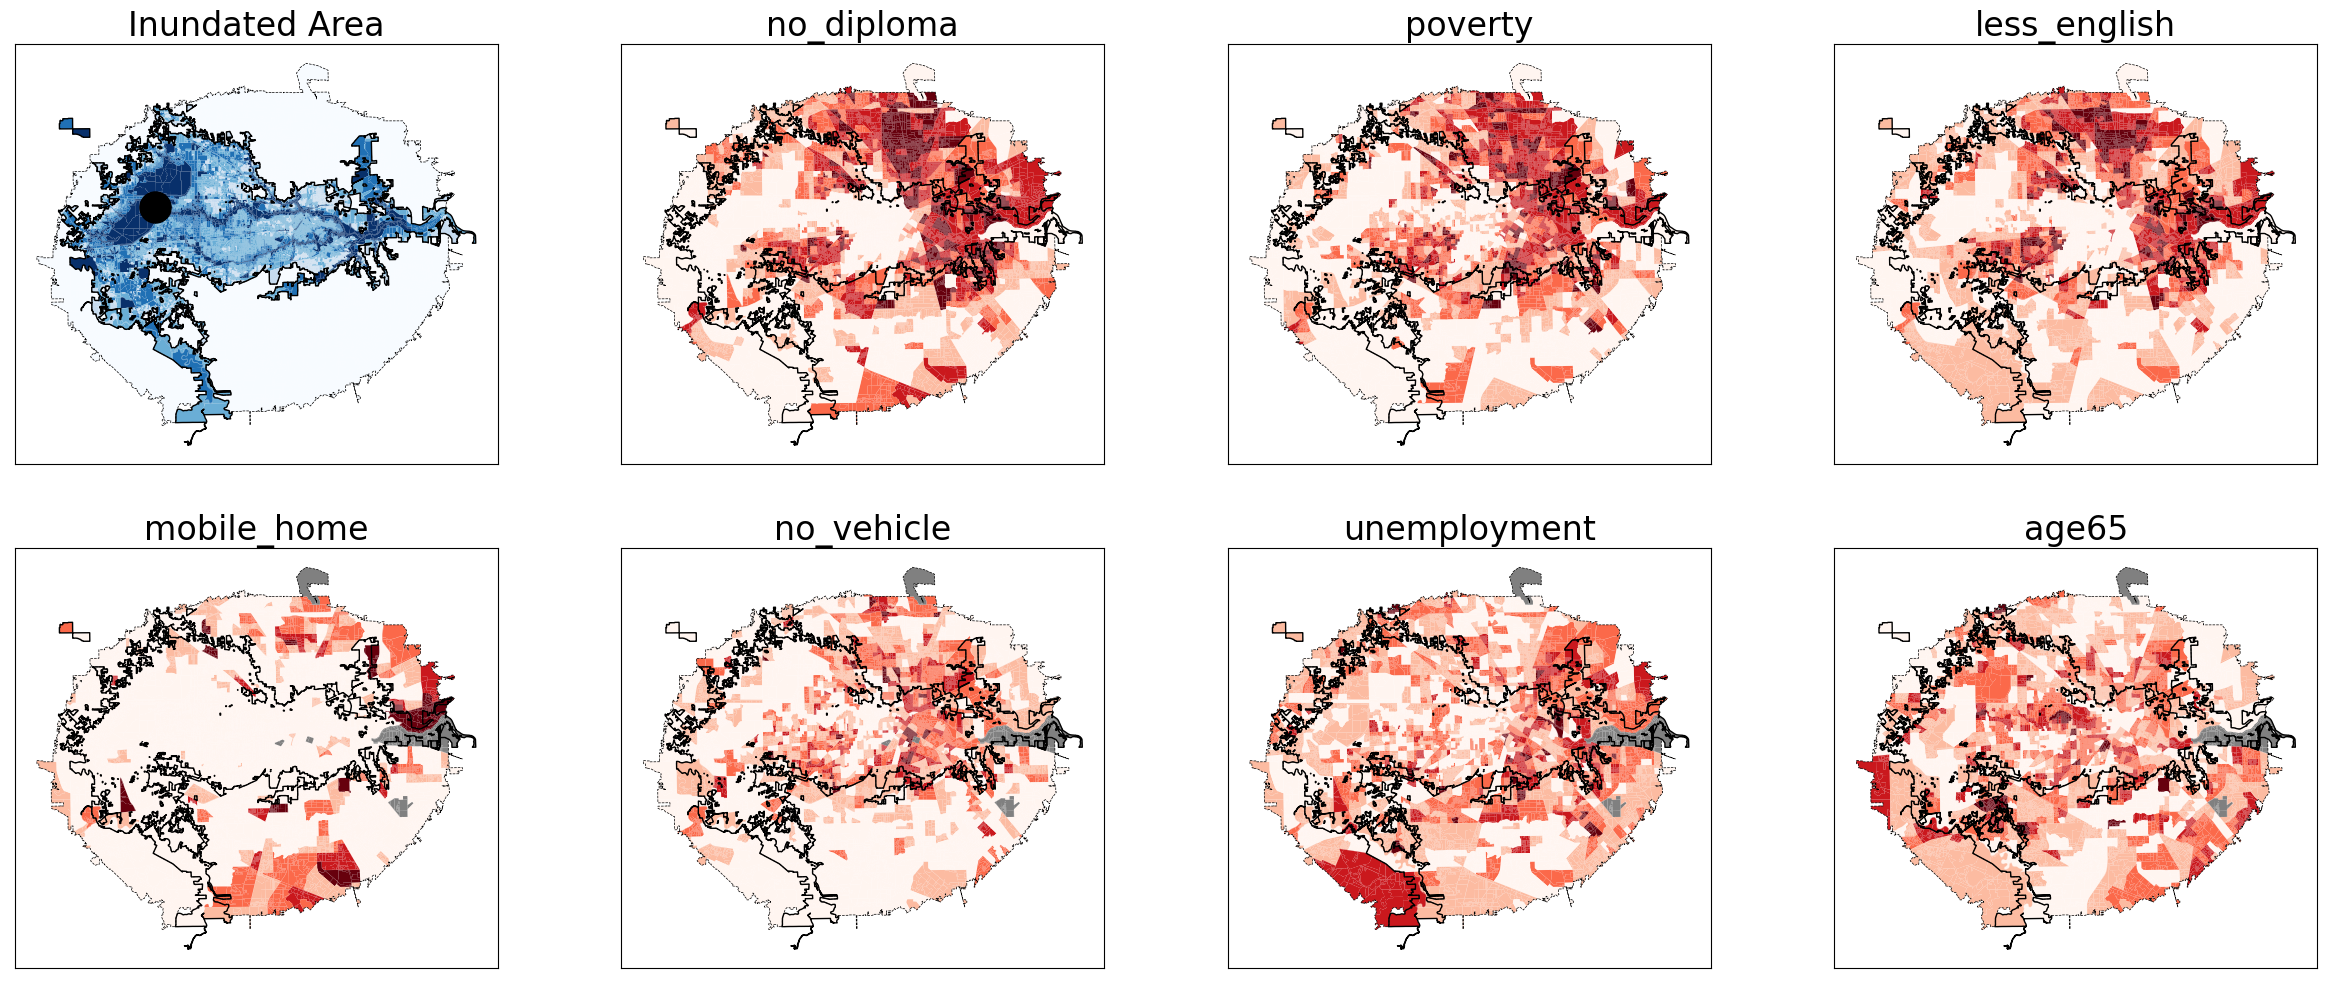

In [16]:
def plot_vulnerability_attribute_around_dam(dam_id):
    fig, axes = plt.subplots(2, 4, figsize=(30,12))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = fim_census.loc[fim_census['Dam_ID'] == dam_id].reset_index()
    scene = dam_area.loc[0, 'Scenario']

    benchmark_area = dam_area.loc[dam_area['Class'] == 0]
    inund_area = dam_area.loc[dam_area['Class'] > 0]
    benchmark_area_union = benchmark_area.dissolve(by='Dam_ID')
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    fed_dams_focus = fed_dams.loc[fed_dams['ID'] == dam_id].reset_index()

    # Plot maps
    var_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']
    for m in range(8):
        if m == 0:
            fim_census.plot('Class', cmap='Blues', ax=ax[m])
            fed_dams_focus.plot(ax=ax[m], markersize=500, color='black')
            ax[m].set_title(label="Inundated Area", fontsize=24)
        else:
            dam_area.loc[dam_area[var_list[m-1]] != -666666666].plot(var_list[m-1], ax=ax[m], scheme='FisherJenks', cmap='Reds')
            dam_area.loc[dam_area[var_list[m-1]] == -666666666].plot(ax=ax[m], color='Grey')
            ax[m].set_title(label=f"{var_list[m-1]}", fontsize=24)
#             ax[m].set_title(label=f"{var_list[m-1]} ({fed_dams_focus['c_' + var_list[m-1]].values[0]})", fontsize=24)
        benchmark_area_union.boundary.plot(ax=ax[m], color='black', lw=0.5, linestyle='dashed')
        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.show()
    
for dam_id in fed_dams['ID'].unique():
    plot_vulnerability_attribute_around_dam(dam_id)

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/esda/moran.py:1361: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/esda/moran.py:1361: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/esda/moran.py:1361: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/esda/moran.py:1361: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/esda/moran.py:1361: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/esda/moran.py:1361: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 44856, 44983.
  warnings.warn(message)


('WARNING: ', 44856, ' is an island (no neighbors)')
('WARNING: ', 44983, ' is an island (no neighbors)')


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/esda/moran.py:1361: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


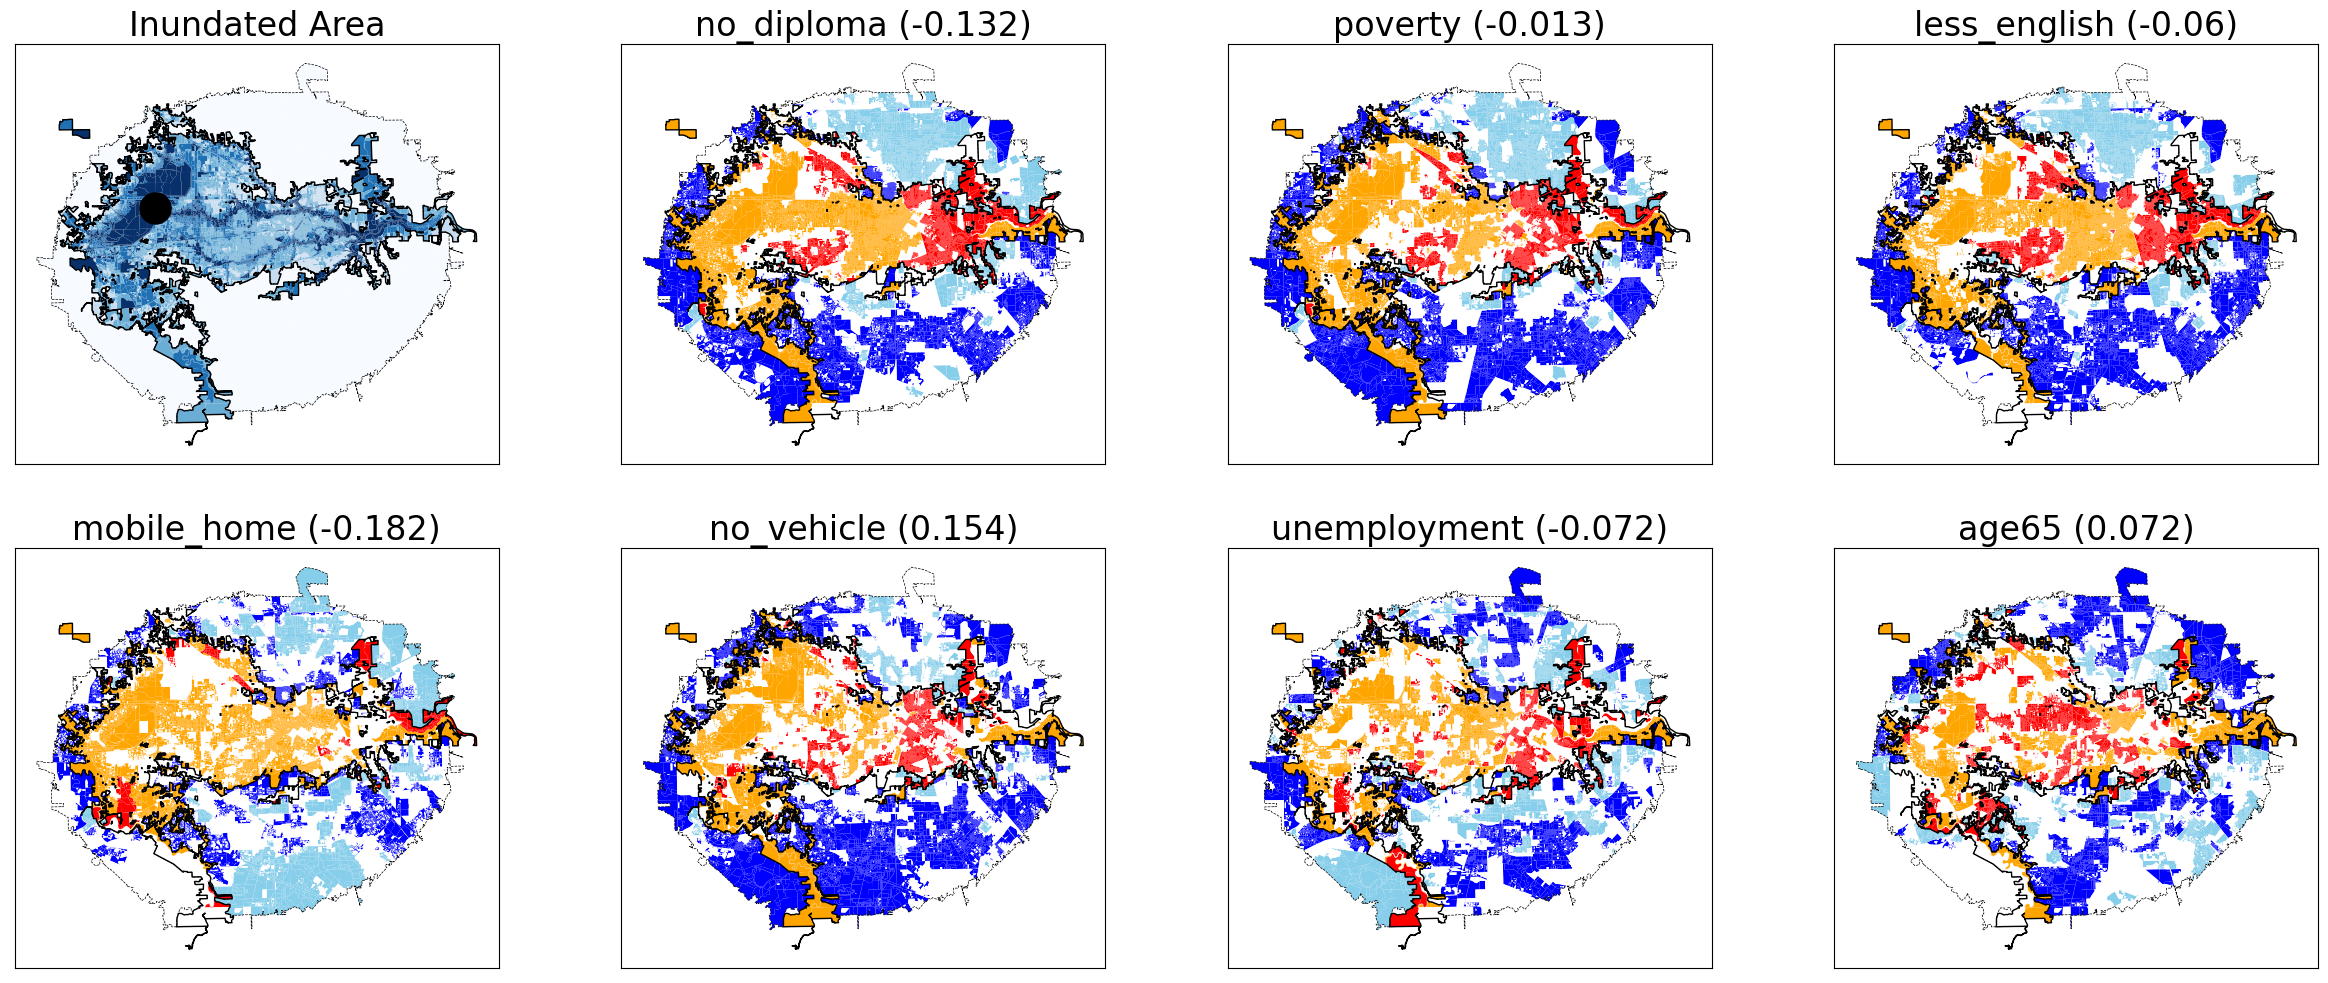

In [17]:
def calculate_bivariate_moran_i(gdf, var):
    w = libpysal.weights.Queen.from_dataframe(gdf)
    bi_mi = esda.Moran_BV(gdf['Class'], gdf[var], w)
    bi_lm = esda.Moran_Local_BV(gdf['Class'], gdf[var], w)
    
    lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
    bi_lm_result = []
    for idx in range(len(bi_lm.q)):
        if bi_lm.p_sim[idx] < 0.05:
            bi_lm_result.append(lm_dict[bi_lm.q[idx]])
        else:
            bi_lm_result.append('Not_Sig')

    return round(bi_mi.I, 3), pd.Series(bi_lm_result)
    
def plot_bivariate_moran_i_and_local_moran_i(dam_id):
    fig, axes = plt.subplots(2, 4, figsize=(30,12))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = fim_census_p.loc[fim_census_p['Dam_ID'] == dam_id].reset_index()
    scene = dam_area.loc[0, 'Scenario']

    benchmark_area = dam_area.loc[dam_area['Class'] == 0]
    inund_area = dam_area.loc[dam_area['Class'] > 0]
    benchmark_area_union = benchmark_area.dissolve(by='Dam_ID')
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    fed_dams_focus = fed_dams.loc[fed_dams['ID'] == dam_id].reset_index()
    fed_dams_focus = fed_dams_focus.to_crs(epsg=5070)

    # Plot maps
    var_list = ['no_diploma', 'poverty', 'less_english', 'mobile_home', 'no_vehicle', 'unemployment', 'age65']
    for m in range(8):
        if m == 0:
            fim_census_p.plot('Class', cmap='Blues', ax=ax[m])
            fed_dams_focus.plot(ax=ax[m], markersize=500, color='black')
            ax[m].set_title(label="Inundated Area", fontsize=24)
        else:
            bi_mi, bi_lm = calculate_bivariate_moran_i(dam_area, var_list[m-1])
            
            lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'white'}
            fim_census_p[f'{var}_lm'] = bi_lm
            
            for key in lisa_color.keys():
                fim_census_p.loc[fim_census_p[f'{var}_lm'] == key].plot(ax=ax[m], color=lisa_color[key], legend=True)
            
            ax[m].set_title(label=f"{var_list[m-1]} ({bi_mi})", fontsize=24)

        benchmark_area_union.boundary.plot(ax=ax[m], color='black', lw=0.5, linestyle='dashed')
        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.show()
    
for dam_id in fed_dams['ID'].unique():
    plot_bivariate_moran_i_and_local_moran_i(dam_id)